## Ticket 1.4.3: Conduct preliminary feature importance analysis

Use simple models to rank features by importance

Compare feature importance between H1N1 and seasonal flu targets

Feature selection techniques help us find the features that are most relevant to our prediction target, which can allow us to build both faster and more effective models. 

1st step: We'll apply a simple filter method to rank features based off statistical measures.

2nd (possible) step: Utilize random forest or gradient boost techniques to perform feature ranking

In [13]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [14]:
# Load training data

# Path is anchored relative to this notebook location
ROOT = Path.cwd().parent

PRO_DATA = ROOT / "data" / "processed"
RAW_DATA = ROOT / "data" / "raw"

training_features = pd.read_csv(PRO_DATA / "training_encoded.csv")
training_labels = pd.read_csv(RAW_DATA / "training_set_labels.csv")

training_data = training_features.merge(training_labels, on='respondent_id')

print(f"Merged dataset shape: {training_data.shape}")

Merged dataset shape: (26707, 57)


In [15]:
training_data.columns[:]

Index(['Unnamed: 0', 'respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'income_poverty', 'household_adults', 'household_children',
       'sex_Male', 'marital_status_Missing', 'marital_status_Not Married',
       'rent_or_own_Own', 'rent_or_own_Rent', 'health_insurance_1.0',
       'health_insurance_Missing', 'race_Hispanic', 'race_Other or Multiple',
       'race_White', 'employment_status_Missing',
       'employment_status_Not in Labor Force'

In [16]:
# Let's calculate the statistical significance between features and output (either H1N1 or Seasonal Flu Vaccine)

# Select all features (excluding ids) and take out targets
features = training_data.iloc[:, 2:-2]

targets = training_data[['h1n1_vaccine','seasonal_vaccine']]

In [17]:
# Import necessary functions and libraries

import sys, os
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.visualizations import cramers_v
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2

In [18]:
# Perform chi-square test for H1N1 vaccine
chi2_h1n1, p_h1n1 = chi2(features, targets['h1n1_vaccine'])


cramers_v_list = []
for col in features.columns:
    cm = pd.crosstab(features[col], targets['h1n1_vaccine'])
    if cm.shape[0] < 2 or cm.shape[1] < 2:
        cramers_v_list.append(np.nan)
    else:
        cramers_v_list.append(cramers_v(cm))

# Combine results
chi2_h1n1_results = pd.DataFrame({
    'feature': features.columns,
    'chi2_value': chi2_h1n1,
    'p_value': p_h1n1,
    'cramers_v': cramers_v_list
}).sort_values('chi2_value', ascending=False)

In [19]:
print(f"H1N1 Vaccine Feature Rank")
print(chi2_h1n1_results.head(10))
print(chi2_h1n1_results.tail(10))

H1N1 Vaccine Feature Rank
                        feature   chi2_value        p_value  cramers_v
9              doctor_recc_h1n1  3307.810188   0.000000e+00   0.393932
15            opinion_h1n1_risk  1914.151226   0.000000e+00   0.326003
18            opinion_seas_risk  1222.319922  8.601899e-268   0.256230
10         doctor_recc_seasonal   892.499456  4.191373e-196   0.218795
30         health_insurance_1.0   840.776875  7.357089e-185   0.244811
31     health_insurance_Missing   729.108935  1.399448e-160   0.224588
13                health_worker   672.405011  2.996320e-148   0.167800
14  opinion_h1n1_vacc_effective   495.639893  8.445973e-110   0.301460
17  opinion_seas_vacc_effective   243.320341   7.425798e-55   0.194591
0                  h1n1_concern   201.358892   1.055106e-45   0.121995
                           feature  chi2_value   p_value  cramers_v
42         hhs_geo_region_fpwskwrf    2.327923  0.127071   0.007688
48         hhs_geo_region_qufhixun    1.847842  0.174035 

#### H1N1 Vaccine Feature Importance Results 

* Doctor recommendation (doctor_recc_h1n1) – strongest predictor (χ²≈3308, Cramér's V≈0.39).

* Perceived risk of H1N1 (opinion_h1n1_risk) – high association (χ²≈1914, V≈0.33).

* Perceived risk of seasonal flu (opinion_seas_risk) – moderate association (χ²≈1222, V≈0.26).

* Doctor recommendation for seasonal flu (doctor_recc_seasonal) – χ²≈892, V≈0.22.

* Health insurance status – having insurance or missing (likely no insurance) is moderately associated with uptake (χ²≈840–729, V≈0.22–0.24).

* Opinions on vaccine effectiveness – beliefs in H1N1 vaccine effectiveness (χ²≈496, V≈0.30) and seasonal vaccine effectiveness (χ²≈243, V≈0.19).

* Being a health worker has a moderate association (χ²≈672, V≈0.17).

* Personal concern about H1N1 is weakly associated (χ²≈201, V≈0.12).

* Geography, household composition, and race show near-zero Cramér's V, indicating a low association with H1N1 vaccination.

In [20]:
# Perform chi-square test for seasonal vaccine
chi2_flu, p_flu = chi2(features, targets['seasonal_vaccine'])


cramers_v_flu = []
for col in features.columns:
    cm = pd.crosstab(features[col], targets['seasonal_vaccine'])
    if cm.shape[0] < 2 or cm.shape[1] < 2:
        cramers_v_flu.append(np.nan)
    else:
        cramers_v_flu.append(cramers_v(cm))

# Combine results
chi2_flu_results = pd.DataFrame({
    'feature': features.columns,
    'chi2_value': chi2_flu,
    'p_value': p_flu,
    'cramers_v': cramers_v_flu
}).sort_values('chi2_value', ascending=False)

In [21]:
print(f"Seasonal Flu Vaccine Feature Rank")
print(chi2_flu_results.head(10))
print(chi2_flu_results.tail(10))

Seasonal Flu Vaccine Feature Rank
                                 feature   chi2_value        p_value  \
18                     opinion_seas_risk  2794.888237   0.000000e+00   
10                  doctor_recc_seasonal  2421.579654   0.000000e+00   
20                             age_group  1370.370317  5.768612e-300   
17           opinion_seas_vacc_effective   991.273021  1.416462e-217   
15                     opinion_h1n1_risk   866.169464  2.219880e-190   
9                       doctor_recc_h1n1   839.733852  1.240122e-184   
11                 chronic_med_condition   557.625394  2.761707e-123   
24                    household_children   538.442999  4.112971e-119   
13                         health_worker   383.862558   1.794869e-85   
36  employment_status_Not in Labor Force   350.330814   3.590048e-78   

    cramers_v  
18   0.388930  
10   0.360569  
20   0.285158  
17   0.397243  
15   0.220013  
9    0.198376  
11   0.169273  
24   0.118116  
13   0.126711  
36   0.145616

#### Seasonal Flu Vaccine Results

* Perceived risk of seasonal flu (opinion_seas_risk) – strongest predictor (χ²≈2795, V≈0.39).

* Doctor recommendation for seasonal flu (doctor_recc_seasonal) – very strong association (χ²≈2422, V≈0.36).

* Age group – older adults more likely to get vaccinated (χ²≈1370, V≈0.29).

* Belief in seasonal vaccine effectiveness (opinion_seas_vacc_effective) – very strong (χ²≈991, V≈0.40).

* Opinion of H1N1 risk (opinion_h1n1_risk) – moderate association (χ²≈866, V≈0.22).

* Doctor recommendation for H1N1 (doctor_recc_h1n1) – somewhat relevant (χ²≈840, V≈0.20).

* Chronic medical conditions – moderate association (χ²≈558, V≈0.17).

* Being a health worker has weaker influence than for H1N1 (χ²≈384, V≈0.13).

* Employment status (“Not in labor force”) shows small influence (χ²≈350, V≈0.15).

* Geography, child under 6 months, antiviral medication use, and some HHS regions show very low χ² and near-zero Cramér's V.

* Seems like some H1N1-related factors influence seasonal flu intake, suggesting that intake / beliefs around H1N1 vaccine could influence the other. 

In [22]:
chi2_results = pd.merge(
    chi2_h1n1_results.rename(columns={
        'chi2_value': 'chi2_h1n1',
        'p_value': 'p_h1n1',
        'cramers_v': 'cramers_v_h1n1'
    }),
    chi2_flu_results.rename(columns={
        'chi2_value': 'chi2_flu',
        'p_value': 'p_flu',
        'cramers_v': 'cramers_v_flu'
    }),
    on='feature'
)
chi2_results.head()

,feature,chi2_h1n1,p_h1n1,cramers_v_h1n1,chi2_flu,p_flu,cramers_v_flu
0,doctor_recc_h1n1,3307.810188,0.000000e+00,0.393932,839.733852,1.240122e-184,0.198376
1,opinion_h1n1_risk,1914.151226,0.000000e+00,0.326003,866.169464,2.219880e-190,0.220013
2,opinion_seas_risk,1222.319922,8.601899e-268,0.256230,2794.888237,0.000000e+00,0.388930
3,doctor_recc_seasonal,892.499456,4.191373e-196,0.218795,2421.579654,0.000000e+00,0.360569
4,health_insurance_1.0,840.776875,7.357089e-185,0.244811,267.431079,4.119117e-60,0.137953


<Figure size 1000x800 with 0 Axes>

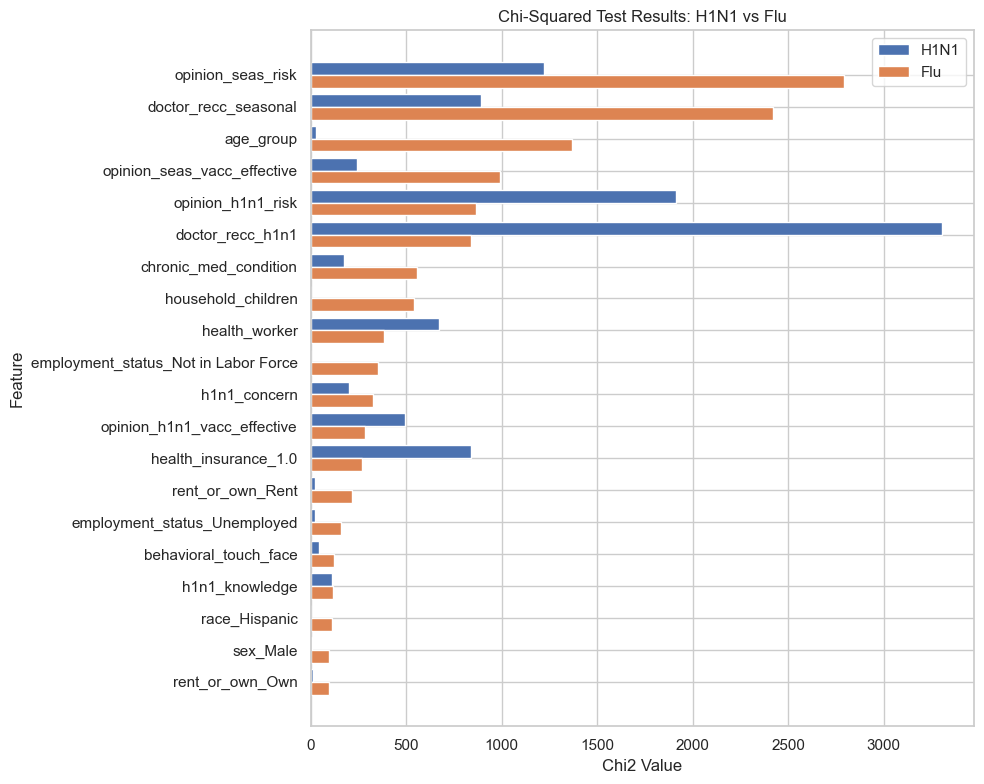

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 8))
chi2_results_sorted = chi2_results.sort_values('chi2_flu', ascending=False).head(20)
features = chi2_results_sorted['feature']

# Set positions for side-by-side bars
y_pos = np.arange(len(features))

plt.figure(figsize=(10, 8))

# Plot side-by-side horizontal bars
plt.barh(y_pos - 0.2, chi2_results_sorted['chi2_h1n1'], height=0.4, label='H1N1')
plt.barh(y_pos + 0.2, chi2_results_sorted['chi2_flu'], height=0.4, label='Flu')

# Reverse the y-axis so the highest value is at the top
plt.yticks(y_pos, features)
plt.gca().invert_yaxis()

plt.xlabel('Chi2 Value')
plt.ylabel('Feature')
plt.title('Chi-Squared Test Results: H1N1 vs Flu')
plt.legend()
plt.tight_layout()
plt.show()


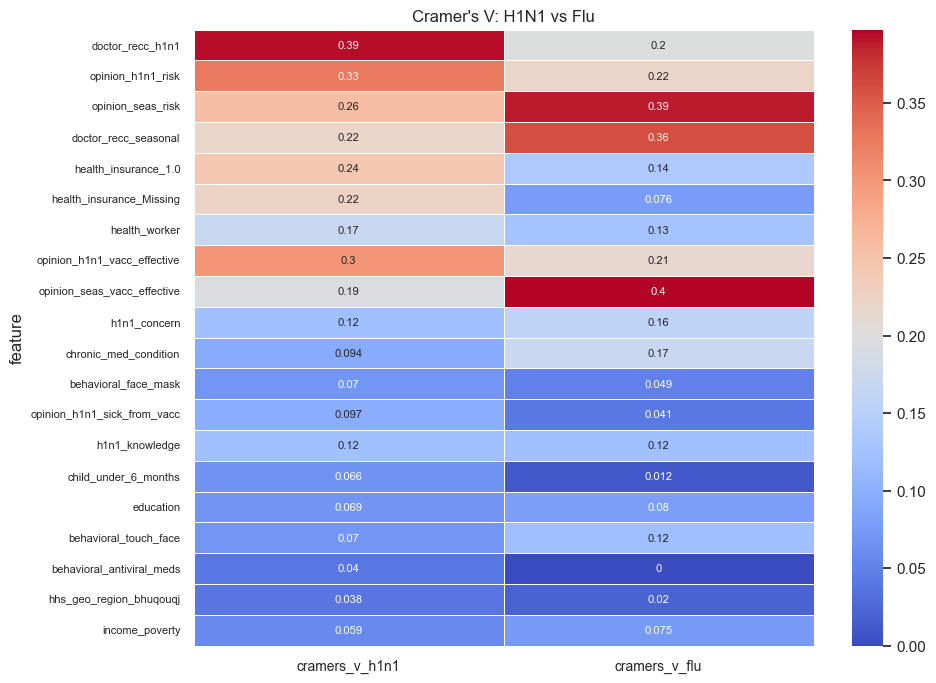

In [24]:
# Show top 10 features

# Select top 10 features by chi2_flu
top20_features = chi2_results.sort_values('chi2_h1n1', ascending=False).head(20)

cramers_v_matrix = top20_features.set_index('feature')[['cramers_v_h1n1','cramers_v_flu']]

plt.figure(figsize=(10,8))
sns.heatmap(
    cramers_v_matrix, 
    annot=True, 
    cmap='coolwarm', 
    linewidths=0.5,
    annot_kws={"size": 8}  # make annotation font smaller
)

plt.xticks(fontsize=10)  # x-axis labels
plt.yticks(fontsize=8, rotation=0)  # y-axis labels
plt.title("Cramer's V: H1N1 vs Flu", fontsize=12)
plt.show()

Cramer's V Effects:

* Age group has a larger effect on seasonal vaccine (0.29) than H1N1 (0.05) - this is a medium effect
* Employment industry and occupation show substantial effects (0.24-0.26) - medium effects
* Education, income, and household variables show small effects (0.07-0.12)
* Sex and marital status have smaller effects despite being statistically significant

#### Conclusions

The least influential features seem to be the geographical data, with doctor recommendation being the most important shared factor for both vaccines.

Perceived personal risk and belief in vaccine effectiveness are major drivers, demographics and geography matter less than personal beliefs and healthcare advice.

H1N1 uptake is associated more directly with H1N1-specific opinions, while seasonal flu uptake is influenced by age and household children.